In [47]:
import matplotlib.pyplot as plt
import json
import numpy as np
import os

from src.data_models.positional.waypoint import Waypoint, Waypoints
from src.data_models.probability_map import ProbabilityMap
from src.waypoint_generation import WaypointFactory, WaypointAlgorithmEnum, WaypointAlgSettings

In [48]:
from src.waypoint_generation import CostFunc
cost_func = CostFunc()

wp_gen_settings = WaypointAlgSettings.Global()

Starting matlab engine...
Matlab engine started as <src.matlab_helper.MatlabHelper object at 0x7f18788932e0>


In [56]:
with open("algorithms_output.json", 'r') as f:
    data = json.loads(json.load(f))
    
img = np.array(data['img'])
del data['img']

for key in WaypointAlgorithmEnum:
    key = str(key)
    try:
        dat = data[key]
        wps = Waypoints(dat['wps'])        
        dat['wps'] = wps
        data[key].update(dat)
        print(f"{key} does exist ({len(wps)} wps)")
    except KeyError:
        print(f"{key} doesn't exist")

WaypointAlgorithmEnum.LHC_GW_CONV does exist (42 wps)
WaypointAlgorithmEnum.PARALLEL_SWATHS does exist (19 wps)
WaypointAlgorithmEnum.MODIFIED_LAWNMOWER does exist (21 wps)
WaypointAlgorithmEnum.PABO does exist (16 wps)


WaypointAlgorithmEnum.PARALLEL_SWATHS
81.4142 units long
0.0894s


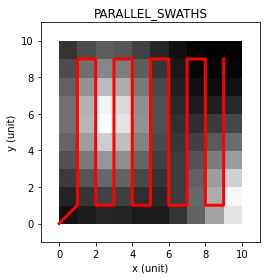

WaypointAlgorithmEnum.MODIFIED_LAWNMOWER
108.4142 units long
10.3846s


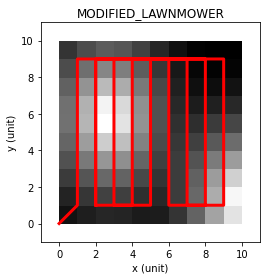

WaypointAlgorithmEnum.PABO
100.8727 units long
73.1026s


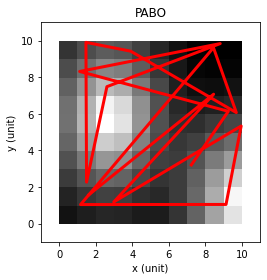

WaypointAlgorithmEnum.LHC_GW_CONV
49.2843 units long
11.8165s


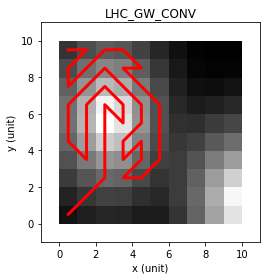

In [57]:
def plot(alg):
    fig, ax = plt.subplots()
    
    ax.imshow(img, interpolation=None,origin='bottom', extent=[0, img.shape[0], 0, img.shape[1]], cmap='gray')
    wps = data[str(alg)]['wps'].toNumpyArray()
    
    dist = np.sum(np.linalg.norm(wps[1:] - wps[:-1],axis=1))
    
    
    
    ax.plot(wps[:,0],wps[:,1],'r',linewidth=3)
        
    ax.set_xlim(-1,img.shape[0]+1)
    ax.set_ylim(-1,img.shape[1]+1)
    ax.set_xlabel("x (unit)")
    ax.set_ylabel("y (unit)")
    
    s = str(alg).split('.')[1]
    fig.savefig(s+"_path.png")
    ax.set_title(s)
    
    return fig,ax,dist
    
    
for key in data.keys():
    fig,ax,dist = plot(key)
    print(f"{key}\n{dist:.4f} units long\n{data[key]['time']:.4f}s")
    plt.tight_layout()
    plt.show()
    data[key]['dist'] = dist

In [51]:
def plot_bar(x,y,x_label,y_label):

    fig,ax = plt.subplots()
    plt.xticks(rotation=45)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.grid(True, linestyle='--', which='major',
                       color='grey', alpha=.25)
    ax.bar(x,y)   

    return fig,ax

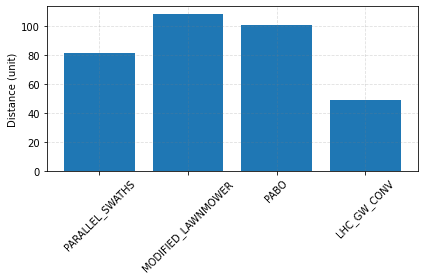

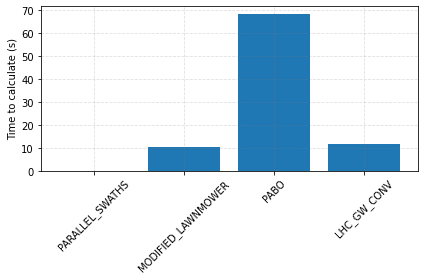

In [52]:
dists = [item[1]['dist'] for item in data.items()]
times = [item[1]['time'] for item in data.items()]

x = [str(s).split('.')[1] for s in data.keys()]

fig,ax=plot_bar(x,dists,"","Distance (unit)")
plt.tight_layout()
fig.savefig("unit_distances_all.png")

fig,ax=plot_bar(x,times,"","Time to calculate (s)")
plt.tight_layout()
fig.savefig("time_to_calculate_all.png")

WaypointAlgorithmEnum.PARALLEL_SWATHS
WaypointAlgorithmEnum.MODIFIED_LAWNMOWER
WaypointAlgorithmEnum.PABO
WaypointAlgorithmEnum.LHC_GW_CONV


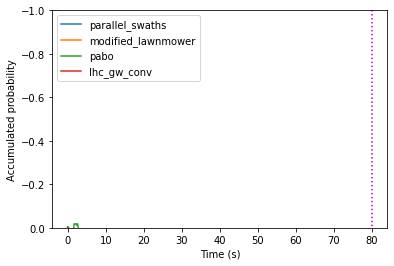

In [58]:
# Cost over distance

# for key in data.keys():
#     wps = data[key]['wps'].toNumpyArray()
#     cost_over_wps = []
#     dist_with_wps = np.cumsum([0]+[np.linalg.norm(g-f) for g,f in zip(wps[:-1],wps[1:])])
#     for i in range(len(wps)):
#         tmp_wps = Waypoints(wps[:i+1])
#         cost = cost_func.calculate(tmp_wps,ProbabilityMap(img),onlyAccumulateProbability=True)
#         cost_over_wps.append(cost)
    
#     print(key)
#     plt.plot(dist_with_wps,cost_over_wps, label=key.split('.')[1].lower())
# plt.ylim([0, -1])
# plt.legend()

# plt.plot((wp_gen_settings['unit_endurance'],)*2,[-1, 1],'m:')
# plt.show()

# Cost over time
for key in data.keys():
    d = data[key]
    v = d['vehicle']
    c_arr = []
    wp_arr = []
    t_arr = []
    for x,y,t in zip(v['pos']['x'],v['pos']['y'],v['t']):
        wp_arr.append(Waypoint(x,y))
        wps = Waypoints(wp_arr)
        cost = cost_func.calculate(wps,ProbabilityMap(img),onlyAccumulateProbability=True)
        t_arr.append(t)
        c_arr.append(cost)    
    print(key)
    plt.plot(t_arr,c_arr, label=key.split('.')[1].lower())


plt.xlabel("Time (s)")
plt.ylabel("Accumulated probability")
plt.ylim([0, -1])
plt.legend()

plt.plot((wp_gen_settings.unit_endurance,)*2,[-1, 1],'m:')
plt.show()
